In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from pykalman import KalmanFilter

df = pd.read_csv("D:\gd2ki2\Chuoithoigian\TH3\Gia SMP va SMPcap 2021(Giá thị trường SMP).csv", encoding='latin-1',sep=';')

df.isnull().sum()
print(df.dtypes)


Ngày     object
1       float64
2       float64
3       float64
4       float64
5       float64
6       float64
7       float64
8       float64
9       float64
10      float64
11      float64
12      float64
13      float64
14      float64
15      float64
16      float64
17      float64
18      float64
19      float64
20      float64
21      float64
22      float64
23      float64
24      float64
25      float64
26      float64
27      float64
28      float64
29      float64
30      float64
31      float64
32      float64
33      float64
34      float64
35      float64
36      float64
37      float64
38      float64
39      float64
40      float64
41      float64
42      float64
43      float64
44      float64
45      float64
46      float64
47      float64
48      float64
dtype: object


In [105]:
df.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [106]:
df = df.iloc[:, [6, 10, 30]]  
df.columns = ['Column7', 'Column11', 'Column31']

In [107]:
print(df.describe())


           Column7     Column11     Column31
count   365.000000   365.000000   365.000000
mean   1040.228767  1040.277808  1040.337808
std     105.146665   105.153179   105.152717
min     885.700000   885.700000   881.500000
25%     988.400000   988.400000   988.400000
50%    1022.600000  1022.600000  1022.600000
75%    1061.500000  1061.500000  1061.600000
max    1565.500000  1565.500000  1565.500000


In [108]:
df.head()

,Column7,Column11,Column31
0,964.4,964.4,964.4
1,1019.7,1019.7,1019.7
2,988.4,988.4,988.4
3,1002.0,1002.1,1010.8
4,1061.5,1061.5,1061.5


## EDA

c:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


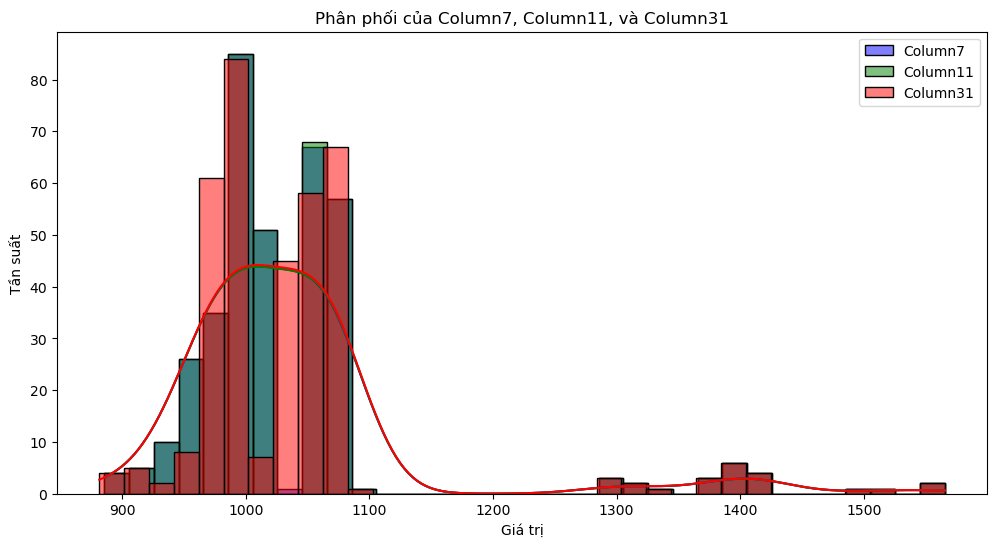

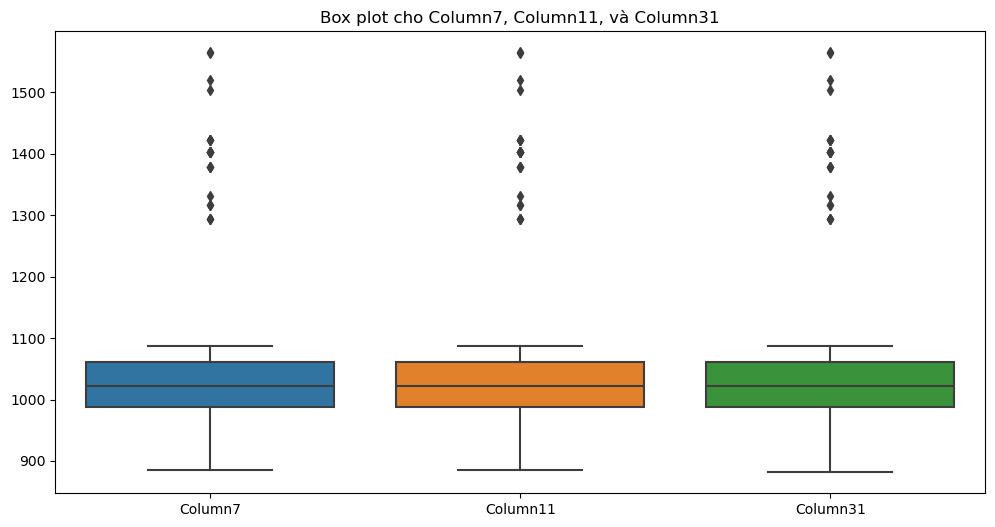

In [109]:

# Vẽ biểu đồ phân phối cho từng cột
plt.figure(figsize=(12, 6))
sns.histplot(df['Column7'], kde=True, color='blue', label='Column7')
sns.histplot(df['Column11'], kde=True, color='green', label='Column11')
sns.histplot(df['Column31'], kde=True, color='red', label='Column31')
plt.title('Phân phối của Column7, Column11, và Column31')
plt.xlabel('Giá trị')
plt.ylabel('Tần suất')
plt.legend()
plt.show()

# Vẽ biểu đồ hộp (box plot) cho các cột
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title('Box plot cho Column7, Column11, và Column31')
plt.show()



## Kalman


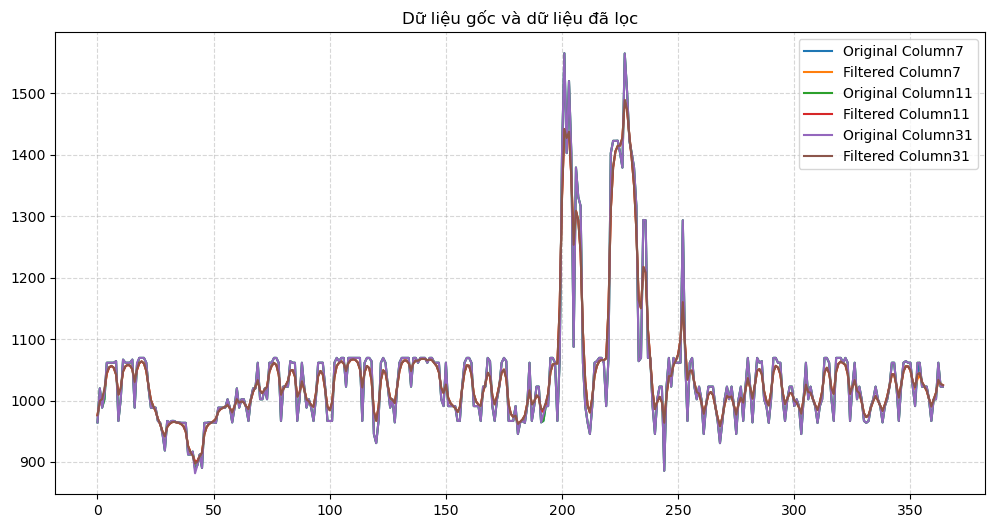

In [110]:
measurements = df.values
kf = KalmanFilter(initial_state_mean=measurements[0], n_dim_obs=measurements.shape[1])
state_means, state_covariances = kf.smooth(measurements)

filtered_data = pd.DataFrame(state_means, columns=[f'filtered_{i}' for i in range(1, measurements.shape[1] + 1)])


plt.figure(figsize=(12, 6))
for i, column in enumerate(df.columns):
    plt.plot(df.index, df[column], label=f'Original {column}')
    plt.plot(df.index, filtered_data[f'filtered_{i+1}'], label=f'Filtered {column}')
plt.legend()
plt.title('Dữ liệu gốc và dữ liệu đã lọc')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## SARIMA


In [111]:
df.head()

,Column7,Column11,Column31
0,964.4,964.4,964.4
1,1019.7,1019.7,1019.7
2,988.4,988.4,988.4
3,1002.0,1002.1,1010.8
4,1061.5,1061.5,1061.5


In [112]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
series = df.iloc[:, 0]

series = series.interpolate(method='linear')

order = (1, 1, 1)         
seasonal_order = (1, 1, 1, 12)  

model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            Column7   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1966.083
Date:                            Tue, 21 May 2024   AIC                           3942.165
Time:                                    11:49:30   BIC                           3961.483
Sample:                                         0   HQIC                          3949.853
                                            - 365                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9983      4.632      0.216      0.829      -8.081      10.078
ma.L1         -0.9992      9.544   

SARIMA - MSE: 7106.405964644386
SARIMA - MAE: 43.265167561265706
SARIMA - RMSE: 84.29950156818477


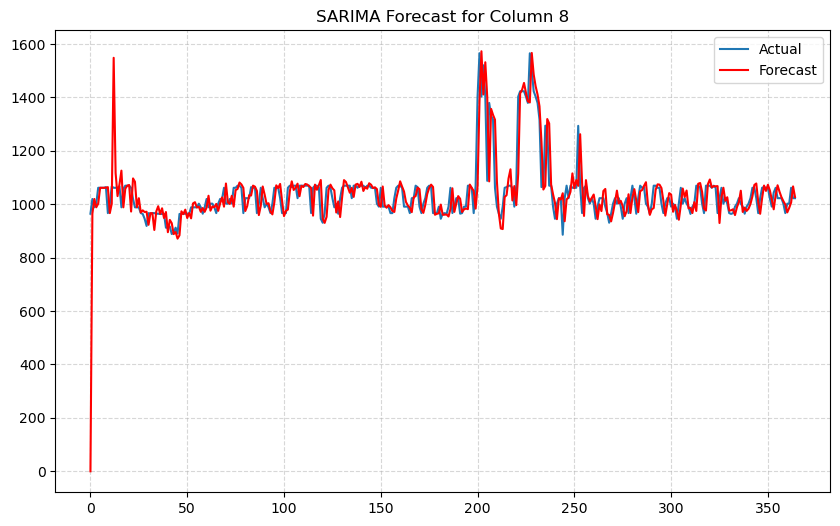

In [113]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Dự đoán giá trị
n_forecast = len(series)
forecast = model_fit.predict(start=0, end=n_forecast-1)

# Tính toán độ đo lỗi
mse = mean_squared_error(series, forecast)
mae = mean_absolute_error(series, forecast)
rmse = np.sqrt(mse)

print("SARIMA - MSE:", mse)
print("SARIMA - MAE:", mae)
print("SARIMA - RMSE:", rmse)

# Vẽ biểu đồ kết quả dự đoán
plt.figure(figsize=(10, 6))
plt.plot(series, label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.title('SARIMA Forecast for Column 8')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()